<center><B><h2>Stock exchage Python project</h2></B></center><br>
<h4><i>Made by : El Achiri Imad & Samir Jabbar</i><br>
<i>Tutored by: Pr. A. Ratnani Co-Supervisors: J, Maaouni & N.Ouhaddou</i></h4>

In [189]:
#importing the packages
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
!pip install ta
from ta.momentum import RSIIndicator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [190]:
def aspx_to_csv(aspx_file,output_name):
  with open('Telechargement-Histo-Valeur.aspx', 'r') as file:# Read the contents of the file into a variable
    aspx_contents = file.read()
  soup = BeautifulSoup(aspx_contents, 'html.parser')# reading the contents of the file into a variable
  # Find the table with the specified id
  table = soup.find('table', {'id': 'GridHistValeur'}) # Find the table of the data
  dict={}#dictionary to store the data
  headers=table.find('tr')# Find the headers of the table (names of the columns)
  colnames=[col.text.strip() for col in headers.find_all('td')]#create a list of the column names
  for header in colnames:
    dict[header]=[]#create a dictionary with the column names as keys
  # Find all rows in the table
  rows = table.find_all('tr')
  # Iterate through each row
  for row in rows:
    # Find all cells in the row
    cells = row.find_all('span')# finding the cells with type span
    cell=[cell.text.strip() for cell in cells]#create a list of the cells and remving the spaces
    L=[i.replace(",",".") for i in cell]#removing the commas from the numbers and replacing them with dots
    s=",".join(L)#joining the list of cells into a string
    for i in range(len(L)): #iterating through the list of cells
        dict[colnames[i]].append(L[i])#adding the cells to the dictionary
    pd.DataFrame(dict).to_csv(output_name,index=False) #converting the dictionary to a dataframe and saving it as a csv file

In [191]:
aspx_to_csv("BMCI.aspx","BMCI.csv")
df=pd.read_csv('BMCI.csv')

Previewing the data:

In [ ]:
df.head()

,Séance,COURS_CLOTURE,COURS_AJUSTE,EVOLUTION,QUANTITE_ECHANGE,VOLUME
0,01/12/2022,410.00,410.00,1.74,16537,6781578.30
1,30/11/2022,403.00,403.00,-1.47,62881,25385455.15
2,29/11/2022,409.00,409.00,-0.24,19363,7927594.65
3,28/11/2022,410.00,410.00,0.01,26033,10676550.00
4,25/11/2022,409.95,409.95,1.72,6136,2509855.00


The number of rows:

In [ ]:
df.shape[0]

732

In [195]:
class Stock:
    """
    The Stock class is used to handle stock market data. It is initialized with the name of the stock and the path to a csv file containing the data.
    It provides several methods to analyze and visualize the data, including:
    - plot: Plot the closing prices and trading volume on a graph
    - max_value: Return the highest closing price
    - min_value: Return the lowest closing price
    - max_volume: Return the highest trading volume
    - max_quantite: Return the highest trading quantity
    - momentum: Return the momentum for a given N
    - sma_n: Return the simple moving average for a given window size
    - visualize: Plot the closing prices, trading volume, momentum and simple moving average on a graph
    """
    #the initializing method of our class, which creates its instances
    def __init__(self, name, csv_file):
        self.name = name
        #we reverse the data, because it had descending date
        self.data = pd.read_csv(csv_file).iloc[::-1]
    #Task 3 plot
    def plot(self):
      #making the plot bigger to be more visible
        plt.rcParams['figure.figsize'] = [18, 8]
        fig, ax1 = plt.subplots()
        #we use twinx in order to have two y-axis at the same time
        #due to different ranges (Volume is much larger than Close prices)
        #so this is the better approach to see them all in the same graph
        ax2 = ax1.twinx()
        #The closing price
        ax1.plot(self.data['Séance'], self.data['COURS_CLOTURE'], 'g-')
        #the volume
        ax2.plot(self.data['Séance'], self.data['VOLUME'], 'b-')
        #the x-axis label
        ax1.set_xlabel('Date')
        #these labels are to differentiate between the two y-axis
        ax1.set_ylabel('Close', color='g')
        ax2.set_ylabel('Volume', color='b')
        #l has the number of rows in data
        l = self.data.shape[0]
        #there are many dates in the x-axis, we need to only show a few
        #to make them readable, we do this with the help of xticks
        plt.xticks(self.data.index[::60])
        #show the legend to differentiate between different curves
        plt.title("Volume and Close")
        plt.legend()
        plt.show()

    def max_value(self):#creating a method to calculate the maximum value of the closing price
        return self.data['COURS_CLOTURE'].max()#returning the maximum value of the closing price

    def min_value(self):#creating a method to calculate the minimum value of the closing price
        return self.data['COURS_CLOTURE'].min()#returning the minimum value of the closing price

    def max_volume(self):#creating a method to calculate the maximum value of the volume
        return self.data['VOLUME'].max()#returning the maximum value of the volume

    def max_quantite(self):#creating a method to calculate the maximum value of the quantity
        return self.data['QUANTITE_ECHANGE'].max()#returning the maximum value of the quantity

    #We ignore this method in order to use a much faster
    #version (proof at the end)
    def momentum(self,N):
      Momentums={}
      for n in N:
        M=[np.nan for _ in range(n)]     
        M+=[self.data.iloc[i]["COURS_CLOTURE"] - self.data.iloc[i-n]["COURS_CLOTURE"] for i in range(n,self.data.shape[0])]
        Momentums[n]=M
      return Momentums
    def momentum_vectorized(self,N):
      #we start with an empty set that will store all of the momentum vectors
      Momentums={}
      #we iterate through the demanded momentums in N
      for n in N:
        #by using shift(n), we can have values from n days ago sitting next to
        #the actual values in the same row, thus, we can calculate the momentum
        #by the difference of the two columns
        Momentums[n] = self.data["COURS_CLOTURE"] - self.data["COURS_CLOTURE"].shift(n)
      return Momentums
    
    def sma_n(self, n_values):
        for n in n_values:#looping on the list of n values
            self.data["SMA_" + str(n)] = self.data["COURS_CLOTURE"].rolling(window=n).mean()#calculating the SMA for each n and adding it to the dataframe

    def visualize(self,N,window_list): #creating a method that plots the SMA and the momentums for a given list of n values
      l=self.data.shape[0]
      Momentums=self.momentum_vectorized(N)#calling the momentum method to calculate the momentums
      plt.rcParams['figure.figsize'] = [18, 8]
      fig, ax1 = plt.subplots()
      ax2 = ax1.twinx()#creating a second axis
      ax1.plot(self.data['Séance'], self.data['COURS_CLOTURE'],label="Close")#plotting the closing price

      self.sma_n(window_list)#calling the sma_n method to calculate the SMA for a given list of n values
      for window in window_list:            
          ax1.plot(self.data["Séance"], self.data["SMA_" + str(window)], label="SMA window =" + str(window))#plotting the SMA for each n value                 

      ax2.plot(self.data['Séance'], self.data['VOLUME'], 'y-',label="Volume")#plotting the volume
      ax1.set_xlabel('Date')
      ax1.set_ylabel('Close and momentums', color='g')
      ax2.set_ylabel('Volume', color='b')
      for id in Momentums:
          #plt.plot(self.data['Séance'], self.data['COURS_CLOTURE'], 'g-',label='Close')
        ax1.plot(self.data['Séance'], Momentums[id],label=f'Momentum={id}')#plotting the momentums for each n value
      l = self.data.shape[0]
      plt.xticks(self.data.index[::60])
      ax1.legend()
      ax2.legend(loc="upper left")
      plt.title("SMA and Momentum")
      plt.show()

      ###################################################
      ##################EXTRA methods#####################
      ###################################################
      ###################################################
    def rsi(self, period):
      """
      Calculates the RSI for a given stock and a given period of time
      Parameters of the method:
      period (int): The period of time (days) to calculate the RSI for.
      Return of the method:
      pandas Series: the rsi result.
      """
      differences = self.data["COURS_CLOTURE"].diff() #computing the difference between the current and the previous value
      positive_returns = differences.where(differences > 0, 0)#if the difference is positive, we keep it, otherwise we set it to 0
      loss = -differences.where(differences < 0, 0)#if the difference is negative, we keep it, otherwise we set it to 0
      avg_gain = positive_returns.rolling(period).mean()#we compute the average gain over the period
      avg_loss = loss.rolling(period).mean()#we compute the average loss over the period
      rs = avg_gain / avg_loss#we compute the relative strength
      rsi = 100 - (100 / (1 + rs))#we compute the rsi
      return rsi
    #The 2nd version of the RSI calculator (using a python library, technical analysis)
    def rsi_v2(self, period):
      return RSIIndicator(close=self.data["COURS_CLOTURE"],window=period).rsi()

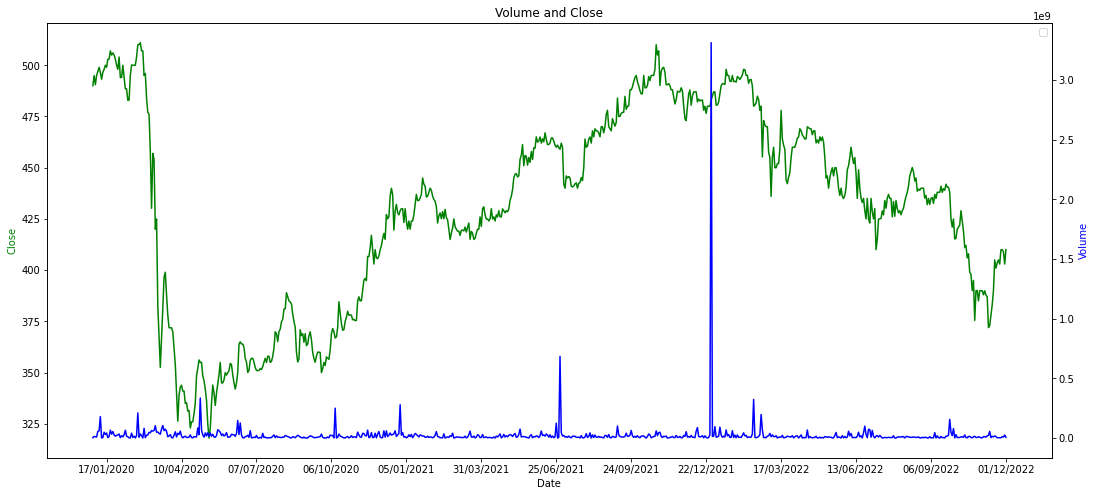

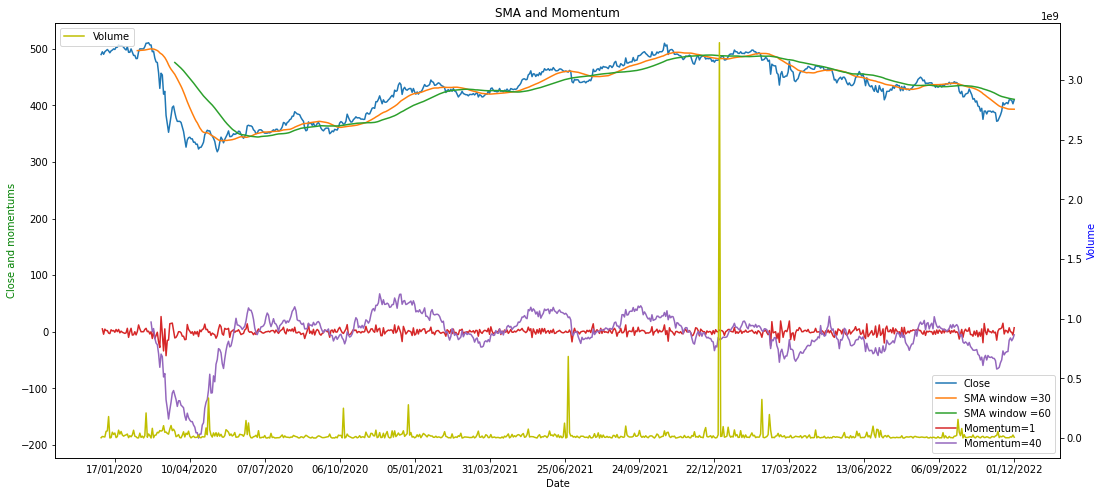

Maximum Close: 511.0
Minimum close: 318.1
Maximum volume: 3312760487.35


In [198]:
#stock object
BMCI = Stock('BMCI', 'BMCI.csv')
BMCI.plot()
BMCI.visualize([1,40],[30,60])
print("Maximum Close:",BMCI.max_value())
print("Minimum close:",BMCI.min_value())
print("Maximum volume:",BMCI.max_volume())

Comparing two functions that calculate the momentum:

In [ ]:
def momentum_vectorized(N,data):
  Momentums={}
  for n in N:
    Momentums[n] = data["COURS_CLOTURE"] - data["COURS_CLOTURE"].shift(n)
  return Momentums

In [ ]:
%timeit momentum_vectorized([1,2,13,75],df)
#the momentum method we had before:
%timeit BMCI.momentum([1,2,13,75])

921 µs ± 74.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
651 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We observe that the vectorized function is much faster ($\sim$ 1000)
So we replace the method we originally had in our Stock class.

And for the SMA,max and min, we implemented the best version possible, because it uses pandas built in functions which are much faster than any algorithm we can write in pure python with loops.

Now we check for the RSI indicator:

In [200]:
%timeit BMCI.rsi(15)
%timeit BMCI.rsi_v2(15)

3.42 ms ± 1.59 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.95 ms ± 20 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


The 2nd version is slightly better.